# University of science
## Advanced Machine Learning - Lab 08 - Build GAN
## Nguyễn Quốc Bảo - 18110053

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPool2D, BatchNormalization, ReLU, GlobalAveragePooling2D, LeakyReLU, Conv2DTranspose
import numpy as np
import matplotlib.pyplot as plt

In [2]:
batch_size = 128 # batch size để đưa vào mô hình huấn luyện
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data() #đọc dữ liệu
all_digits = np.concatenate([x_train, x_test]) 
labels = np.concatenate([y_train,y_test])
all_digits = (all_digits.astype("float32")-127.5) / 127.5 #đưa tấm hình về [-1,1]
all_digits = np.reshape(all_digits,(-1,28,28,1)) #reshape toàn bộ dữ liệu lại
all_digits = tf.data.Dataset.from_tensor_slices(all_digits) #Đưa dữ liệu về dạng tensor

from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoder.fit(np.reshape(np.array(range(0,10)),[-1,1]))
onehot_encoded = onehot_encoder.transform(np.reshape(labels,[-1,1]))
all_labels = tf.data.Dataset.from_tensor_slices(onehot_encoded)

dataset = tf.data.Dataset.zip((all_digits, all_labels))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(32) #shuffle dữ liệu mỗi lần đưa vào mô hình

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
#Mô hình mạng discriminator
Input = tf.keras.layers.Input(shape=(28, 28, 1))
Label = tf.keras.layers.Input(shape=(10,))

LabelDense = tf.keras.layers.Dense(50)(Label)
LabelDense = tf.keras.layers.Dense(28*28)(LabelDense)
LabelDense = tf.keras.layers.Reshape((28,28,1))(LabelDense)

Discriminator = tf.keras.layers.Concatenate()([Input, LabelDense])
Discriminator = tf.keras.layers.BatchNormalization()(Discriminator)
Discriminator = tf.keras.layers.Flatten()(Discriminator)

Discriminator = tf.keras.layers.Dense(units=1024)(Discriminator)
Discriminator = tf.keras.layers.LeakyReLU(alpha=0.2)(Discriminator)
Discriminator = tf.keras.layers.Dropout(0.3)(Discriminator)

Discriminator = tf.keras.layers.Dense(units=512)(Discriminator)
Discriminator = tf.keras.layers.LeakyReLU(alpha=0.2)(Discriminator)
Discriminator = tf.keras.layers.Dropout(0.3)(Discriminator)

Discriminator = tf.keras.layers.Dense(units=256)(Discriminator)
Discriminator = tf.keras.layers.LeakyReLU(alpha=0.2)(Discriminator)
Discriminator = tf.keras.layers.Dropout(0.3)(Discriminator)

Discriminator = tf.keras.layers.Dense(units=1, activation="sigmoid")(Discriminator)

discriminator = tf.keras.models.Model(inputs=[Input, Label], outputs=Discriminator)

discriminator.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 dense_12 (Dense)               (None, 50)           550         ['input_7[0][0]']                
                                                                                                  
 dense_13 (Dense)               (None, 784)          39984       ['dense_12[0][0]']               
                                                                                                  
 input_6 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                            

In [ ]:
#mô hình của mạng Generator
latten_dim = 100

Input = tf.keras.layers.Input(shape=(latten_dim,))
Label = tf.keras.layers.Input(shape=(10,))

LabelDense = tf.keras.layers.Dense(50)(Label)
LabelDense = tf.keras.layers.Dense(256)(LabelDense)

Generator = tf.keras.layers.Dense(units=256)(Input)
Generator = tf.keras.layers.Concatenate()([Generator, LabelDense])

Generator = tf.keras.layers.Dense(units=512)(Generator)
Generator = tf.keras.layers.LeakyReLU(alpha=0.2)(Generator)

Generator = tf.keras.layers.Dense(units=1024)(Generator)
Generator = tf.keras.layers.LeakyReLU(alpha=0.2)(Generator)

Generator = tf.keras.layers.Dense(units=28*28)(Generator)
Generator = tf.keras.layers.Activation(activation="tanh",name="tanh")(Generator)  #Đưa về một tấm ảnh nên dùng tanh để về [-1,1]

Generator = tf.keras.layers.Reshape((28,28,1))(Generator)
Generator = tf.keras.layers.BatchNormalization()(Generator)

generator = tf.keras.models.Model(inputs=[Input, Label], outputs=Generator)


generator.summary()




Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 dense_18 (Dense)               (None, 50)           550         ['input_9[0][0]']                
                                                                                                  
 dense_20 (Dense)               (None, 256)          25856       ['input_8[0][0]']                
                                                                                            

In [3]:
class Gan(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(Gan,self).__init__()
        self.discriminator=discriminator 
        self.generator=generator
        self.latent_dim=latent_dim
    def compile(self, d_optimizer, g_optimizer, loss_function):
        super(Gan,self).compile()
        self.d_optimizer=d_optimizer
        self.g_optimizer=g_optimizer
        self.loss_function=loss_function 
    def train_step(self, real_images):
        # tạo batch size từ dữ liệu đầu vào
        batch_size = tf.shape(real_images[0])[0]
        CLabel = real_images[1] 
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim)) #tạo noises theo phân phối chuẩn

        # Tạo ra ảnh giả từ mạng generator
        generated_images = self.generator([random_latent_vectors ,CLabel])

        # nối ảnh giả và ảnh thật làm bộ dữ liệu cho mô hình discriminator
        combined_images = tf.concat([generated_images, real_images[0]], axis=0)
        combined_CLabel = tf.concat([CLabel, CLabel], axis=0)
        # Ở đây đánh nhãn ảnh giả là 1, ảnh thật là 0
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # trick để add thêm noise cho nhãn
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # huấn luyện discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator([combined_images, combined_CLabel]) #Dự đoán 
            d_loss = self.loss_function(labels, predictions)  #Đưa kết quả dự đoán và grouth-truth vào hàm loss
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        ) #cập nhật weights cho mô hình discrimunator


        # lặp lại bước tạo noise như ở trên
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # tạo mộ bộ nhãn sao cho đều là 1 để đánh lừa discriminator
        misleading_labels = tf.zeros((batch_size, 1))

        # Train generator (lưu ý k update weights cho discriminator)
        with tf.GradientTape() as tape:
            predictions = self.discriminator([self.generator([random_latent_vectors, CLabel]), CLabel])
            g_loss = self.loss_function(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        return {"d_loss": d_loss, "g_loss": g_loss}



In [4]:
#overwrite callback để lúc huấn luyện xem ảnh in ra
from IPython.display import Image, display
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=100):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim)) #Tạo noises
        labels=tf.constant([[0,0,0,0,1,0,0,0,0,0],
                           [0,0,0,0,0,0,1,0,0,0],
                           [0,0,0,0,0,0,0,0,0,1]])
        generated_images = self.model.generator([random_latent_vectors,labels]) #tạo ảnh
        generated_images = generated_images*127.5+127.5 #Đưa ảnh về [0,255]
        generated_images.numpy() 
        print("epoch ",epoch)
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            display(img) #in ảnh

In [ ]:
epochs = 30 #số epochs
latent_dim = 100 #số chiều cho noises
gan = Gan(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003,beta_1=0.5), 
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003,beta_1=0.5),
    loss_function=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=3, latent_dim=latent_dim)],verbose=0
    )

epoch  0


epoch  1


epoch  2


epoch  3


epoch  4


epoch  5


epoch  6


epoch  7


epoch  8


epoch  9


epoch  10


epoch  11


epoch  12


epoch  13


epoch  14


epoch  15


epoch  16


epoch  17


epoch  18


epoch  19


epoch  20


epoch  21


epoch  22


epoch  23


epoch  24


epoch  25


epoch  26


epoch  27


epoch  28


epoch  29


#Bài tập
1. Dụa vào mô hình CGAN ở trên hãy tạo ra một mô hình CGAN theo cấu trúc bên dưới và train trên tập Mnist

2. trong quá trình train in thử ra các con số: 4,6,9

In [5]:
#Create the Generator
latten_dim = 100

Input = tf.keras.layers.Input(shape=(latten_dim,))
Label = tf.keras.layers.Input(shape=(10,))


InputDense = Dense(7*7*256, use_bias=False)(Input)
LabelDense = Dense(49)(Label)
LabelDense = Reshape((7,7,1))(LabelDense)

Generator = Reshape((7,7,256))(InputDense)

Generator = tf.keras.layers.Concatenate()([Generator, LabelDense])
Generator = BatchNormalization()(Generator)
Generator = keras.layers.Conv2DTranspose(filters=128,
                            kernel_size=[5,5],
                            strides=(1,1),    #muốn gấp đôi kích thước tấm ảnh thì dùng stride=2
                            padding="same",
                            use_bias=False)(Generator)
Generator = BatchNormalization()(Generator)
Generator = LeakyReLU(alpha=0.2)(Generator)
Generator = keras.layers.Conv2DTranspose(filters=64,
                            kernel_size=[5,5],
                            strides=(2,2),    #muốn gấp đôi kích thước tấm ảnh thì dùng stride=2
                            padding="same",
                            use_bias=False)(Generator)
Generator = BatchNormalization()(Generator)                            
Generator = LeakyReLU(alpha=0.2)(Generator)
Generator = keras.layers.Conv2DTranspose(filters=1,
                            kernel_size=[5,5],
                            strides=(2,2),    #muốn gấp đôi kích thước tấm ảnh thì dùng stride=2
                            padding="same",
                            use_bias=False)(Generator)
Generator = Reshape((28,28,1))(Generator)
generator = tf.keras.models.Model(inputs=[Input, Label], outputs=Generator, name='Generator')


generator.summary()

Model: "Generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 12544)        1254400     ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 49)           539         ['input_2[0][0]']                
                                                                                          

In [6]:
# Create the Discriminator
Input = tf.keras.layers.Input(shape=(28, 28, 1))
Label = tf.keras.layers.Input(shape=(10,))

LabelDense = Dense(784)(Label)
LabelDense = Reshape((28,28,1))(LabelDense)

Discriminator = tf.keras.layers.Concatenate()([Input, LabelDense])
Discriminator = keras.layers.Conv2D(filters=64,
                            kernel_size=[5,5],
                            strides=(2,2),    #muốn gấp đôi kích thước tấm ảnh thì dùng stride=2
                            padding="same",
                            use_bias=True)(Discriminator)
Discriminator = LeakyReLU(alpha=0.2)(Discriminator)
Discriminator = keras.layers.Conv2D(filters=128,
                            kernel_size=[5,5],
                            strides=(2,2),    #muốn gấp đôi kích thước tấm ảnh thì dùng stride=2
                            padding="same",
                            use_bias=True)(Discriminator)                            
Discriminator = LeakyReLU(alpha=0.2)(Discriminator)
Discriminator = Flatten()(Discriminator)
Discriminator = Dense(units=1, activation="sigmoid")(Discriminator)

discriminator = tf.keras.models.Model(inputs=[Input, Label], outputs=Discriminator, name='Discriminator')

discriminator.summary()

Model: "Discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 dense_2 (Dense)                (None, 784)          8624        ['input_4[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 reshape_3 (Reshape)            (None, 28, 28, 1)    0           ['dense_2[0][0]']                
                                                                                      

In [7]:
epochs = 31 #số epochs
latent_dim = 100 #số chiều cho noises
gan = Gan(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003,beta_1=0.5), 
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003,beta_1=0.5),
    loss_function=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=3, latent_dim=latent_dim)],verbose=0
    )

epoch  0


epoch  1


epoch  2


epoch  3


epoch  4


epoch  5


epoch  6


epoch  7


epoch  8


epoch  9


epoch  10


epoch  11


epoch  12


epoch  13


epoch  14


epoch  15


epoch  16


epoch  17


epoch  18


epoch  19


epoch  20


epoch  21


epoch  22


epoch  23


epoch  24


epoch  25


epoch  26


epoch  27


epoch  28


epoch  29


epoch  30


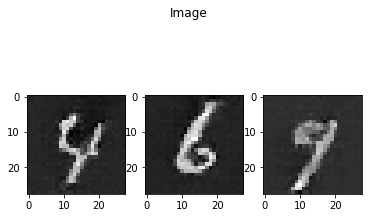

In [9]:
def predict_gan(num_img = 3):
    labels=tf.constant([[0,0,0,0,1,0,0,0,0,0],
                           [0,0,0,0,0,0,1,0,0,0],
                           [0,0,0,0,0,0,0,0,0,1]])
    random_latent_vectors = tf.random.normal(shape=(num_img, 100))
    generated_images = gan.generator([random_latent_vectors,labels]) #tạo ảnh
    generated_images = generated_images*127.5+127.5
    generated_images.numpy()
    fig, axs = plt.subplots(1,num_img)
    fig.suptitle('Image')
    for i in range(num_img):
        img = keras.preprocessing.image.array_to_img(generated_images[i])
        axs[i].imshow(img,  cmap='gray')
predict_gan()